# BULK WEBSITE CONNECTOR

Investigative journalists often need to find information about masses of websites, for example, to find out if they connected or clustered in some ways. 

This script checks an infinite 'checklist' of addresses and finds identifiers such as Google Analytics ID, Yandex ID, WhoIs info and IP addresses.

It puts them into a dataframe and then does a network analysis that shows clusters.

In [1]:
# libraries
import requests
from bs4 import BeautifulSoup, Tag
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import networkx as nx

In [120]:
# insert links here

checklist = ['https://mobilecafe.inbet.cc/',\
             'https://inbetmaxbet-cafe.cc/',\
             'https://papabet.cc',\
             'https://www.krooncasino.cc',\
             'https://planningpoker.cc/',\
             'https://blindpoker.cc/',\
             'https://vbpoker.cc/',\
            'http://dewapoker88.cc/',\
            'http://www.goopoker.cc/',\
            'https://www.betzona.cc/',\
            'https://www.caribebet.cc/',\
            'http://roulette77.cc/',\
            'https://play2x.cc/',\
            'https://betlive.cc/',\
            'https://mg2ovo.cc/',\
            'https://www.jokerclub.cc/',\
            'https://luckygames.cc/',\
            'http://onlineslots.cc/',\
            'http://maxbet-cafe.cc/',\
            'https://betscsgo.cc/',\
            'https://incafe.inbet.cc/',\
            'https://www.flashbet.cc/',\
            'http://mybets.cc/',\
            'http://www.online-keno.cc/',\
            'https://cafe-maxbet.cc/',\
            'https://cafe.inbet.cc/',\
            'https://v-bet.cc/',\
            'https://betscsgo.cc/',\
            'https://mustangbet.cc/',\
            'https://www.12play.cc/',\
            'https://cryptobets.cc/',\
            'http://www.internetpoker.cc/',\
            #'https://www.nodepositbonus.cc/',\
            'https://www.livebet.cc/',\
            'https://www.online-craps.cc/',\
            'https://www.eatforfun.cc/',\
            'https://www.1bet2u.cc/']

### FIND IDENTIFIERS IN THE CODE

Sites that use Google Analytics need to indlude an ID tag in their code. This code can be used by a company/person on a number of sites.

This function searches for Google's UA- and (less used) pub- IDs.

It also looks for Yandex IDs - common on Russian sites.

Bespoke identifiers can also be added. I have asked the script to look for the word 'license'/'licence', and for a term I noticed on one site that I thought could link it to others.


Once the identifiers are collected, a network analysis will show clusters of sites sharing the ID.


---
You can also enter this ID into this address below to find other sites not in the Checklist: https://dnslytics.com/reverse-analytics

In [121]:
def findHeaderIdentifiers(url, s):
     
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    ua, pub, ym, license, oceanside247 = None, None, None, None, None
    
    try:
    
        #### GOOGLE ANALYTICS TAG ID UA
        j = soup.find_all("script")    
        for i in j:
            if 'UA-' in str(i):             
                ua = 'UA-' + str(i).split('UA-')[1][:12].replace('"',"'").split("'")[0]  
                
        #### GOOGLE ANALYTICS TAG ID PUB
        j = soup.find_all("script")    
        for i in j:
            if 'pub-' in str(i):             
                pub = 'pub-' + str(i).split('pub-')[1][:12].replace('"',"'").split("'")[0]

        #### YANDEX ID
        j = soup.find_all("img")
        st = 'mc.yandex.ru/watch/'
        for i in j:
            if st in str(i):
                    ym = re.search('%s(.*)%s' % (st, '" '), str(i)).group(1)
                    
                    
        if 'license' in str(soup).lower() or 'lisense' in str(soup).lower():             
            license = True
            
        # bespoke identifier
        if 'OceanSide247.com' in str(soup):             
            oceanside247 = True
                    
    except:
        print('!!!!', url)
    
    identifiers_d[s] = dict(UA=ua, PUB=pub,  YM=ym, license=license, oceanside247=oceanside247)

### FIND IP ADDRESSES

Websites have IP Addresses, and from this, the (general) location of the server housing the sites can be found. 

This does not mean that this is the comapny's headquarters: sites are often stored on servers run by tech storage giants like Cloudflare, with many, many other unrelated sites.

The CheckHost site returns three different addresses. I have always found the first is the most likely.

In [122]:
def findIPs(site,s):
        
    url = "https://check-host.net/ip-info?host=" + site
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    tables = soup.find_all('table', attrs={'class':'inside_info'})

    i = 1
    for table in tables:
        
        ip_x = 'IP_'+ str(i)
        i += 1        
        rows = table.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            if len(str(cols)) < 100:
                try:
                    if cols[0] == 'IP address' or cols[0] == 'Country'  or cols[0] == 'Region'  or cols[0] == 'City':    
                        k = cols[0]
                        if cols[0] == 'Country':
                            v = cols[1].split('\n')[1]
                            v = v.replace('(','').replace(')','')
                        else:
                            v = cols[1]
                        identifiers_d[s][ip_x +': ' + k] = v
                except:
                    continue

### WHOIS finder

In [123]:
def findWhoIs(site,s):
    
    url = "https://www.whois.com/whois/" + s
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    print('WHOIS: ', url)
    
    j = soup.find("div", {"class": "df-block-raw"}).contents[1].get_text()
    j = j.split('>>> Last update')[0]
    j = j.split('\n')
    for i in j:
        try:
            k,v = i.split(':',1)
            v = v.replace('\r','').strip()
            identifiers_d[s][k] = v 
        except:
            continue

### DOMAIN BIG DATA Search

Domain Big Data stores HISTORIC (and current) WHoIs data, so if ownership is not showing in WhoIs, it may be on DBD.

(A new column for historic data is only made if this data is found in at least one entry.)

In [125]:
def findDBD(site,s):
 
    url = "https://domainbigdata.com/" + s 
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    def getInfo(idequals, dname, v1,):
        
        try:
            
            bit = soup.find(id=idequals)
            
            if v1 == 'TD1':    
                bit = bit.find_all("td")[1]
                
            if bit.find('a') != None:
                bit = bit.find("a")
            
            bit = bit.contents[0]

        except:
            bit = None

        identifiers_d[s]['DBD ' + dname] = bit
    
    getInfo("trRegistrantName", 'Registrant Name', 'TD1')
    getInfo('MainMaster_trRegistrantOrganization', 'Registrant Organisation', None)
    getInfo("trRegistrantEmail", 'Registrant Email', 'TD1')
    getInfo("trRegistrantTel", 'Registrant Phone', 'TD1')
    
    historical = soup.find_all(id='divRptHistoryMain')
    for n in range(0,len(historical)):        
        getInfo("trRegistrantNameInRpt", 'Historic Name ' + str(n), 'TD1')
        getInfo('MainMaster_rptWhoisHistory_trRegistrantOrganizationInRpt_' + str(n), 'Historic Org ' + str(n), 'TD1')
        getInfo('trRegistrantEmailInRpt', 'Historic Email ' + str(n), 'TD1')
        getInfo('trRegistrantAddressInRpt', 'Historic Address ' + str(n), 'TD1')
        getInfo('trRegistrantTelInRpt', 'Historic Telephone ' + str(n), 'TD1')
        getInfo('trRegistrantFaxInRpt', 'Historic Fax ' + str(n), 'TD1')
              
    print(url)

In [136]:
identifiers_d = {}
for site in checklist:
    
    s = site.replace('https','').replace('http','').replace('://','').replace('www.','').replace('/','')
    identifiers_d[s] = {}
    
    findHeaderIdentifiers(site, s) 
    findIPs(site,s)
    findDBD(site,s)
    findWhoIs(site,s)
    
    print(s)

https://domainbigdata.com/mobilecafe.inbet.cc
WHOIS:  https://www.whois.com/whois/mobilecafe.inbet.cc
mobilecafe.inbet.cc
https://domainbigdata.com/inbetmaxbet-cafe.cc
WHOIS:  https://www.whois.com/whois/inbetmaxbet-cafe.cc
inbetmaxbet-cafe.cc
https://domainbigdata.com/papabet.cc
WHOIS:  https://www.whois.com/whois/papabet.cc
papabet.cc
https://domainbigdata.com/krooncasino.cc
WHOIS:  https://www.whois.com/whois/krooncasino.cc
krooncasino.cc
https://domainbigdata.com/planningpoker.cc
WHOIS:  https://www.whois.com/whois/planningpoker.cc
planningpoker.cc
https://domainbigdata.com/blindpoker.cc
WHOIS:  https://www.whois.com/whois/blindpoker.cc
blindpoker.cc
https://domainbigdata.com/vbpoker.cc
WHOIS:  https://www.whois.com/whois/vbpoker.cc
vbpoker.cc
https://domainbigdata.com/dewapoker88.cc
WHOIS:  https://www.whois.com/whois/dewapoker88.cc
dewapoker88.cc
https://domainbigdata.com/goopoker.cc
WHOIS:  https://www.whois.com/whois/goopoker.cc
goopoker.cc
https://domainbigdata.com/betzona.cc


In [138]:
identifiersDF = pd.DataFrame.from_dict(identifiers_d).T
identifiersDF['Site'] = identifiersDF.index               ## makes the network analysis easier to refer to a clumn value, not an index value
identifiersDF.head(2)

UA   PUB        YM license oceanside247  \
mobilecafe.inbet.cc           None  None  27214355    None         None   
inbetmaxbet-cafe.cc  UA-15084876-7  None  27214355    None         None   

                    IP_1: IP address IP_1: Country IP_1: Region IP_1: City  \
mobilecafe.inbet.cc     104.20.82.30            CA       Quebec   Montreal   
inbetmaxbet-cafe.cc      104.28.0.59            CA       Quebec   Montreal   

                    IP_2: IP address  ... Billing State/Province  \
mobilecafe.inbet.cc     104.20.82.30  ...                    NaN   
inbetmaxbet-cafe.cc      104.28.0.59  ...                    NaN   

                    Billing Postal Code Billing Country Billing Phone  \
mobilecafe.inbet.cc                 NaN             NaN           NaN   
inbetmaxbet-cafe.cc                 NaN             NaN           NaN   

                    Billing Phone Ext Billing Fax Billing Fax Ext  \
mobilecafe.inbet.cc               NaN         NaN             NaN   
inbetmaxbet-cafe.cc               NaN         NaN             NaN   

                    Billing Email Nameserver                 Site  
mobilecafe.inbet.cc           NaN        NaN  mobilecafe.inbet.cc  
inbetmaxbet-cafe.cc           NaN        NaN  inbetmaxbet-cafe.cc  

[2 rows x 107 columns]

In [143]:
# pickle

identifiersDF.to_pickle("./pickledinfo.pkl")

# CLUSTERS & ANALYSIS

In [402]:
def drawGraph(graphDF, main, joiner):

    G = nx.Graph()

    ### ADD NODE
    for index, row in graphDF.iterrows():
        a = row[main]
        b = row[joiner]

        G.add_node(a)

        ## FIND EDGE
        for index, row in graphDF.iterrows():
            A = row[main]
            B = row[joiner]

            if b != None:
                if b == B:
                    G.add_edge(a,A)
                    
    plt.figure(1,figsize=(15,6)) 
    pos = nx.spring_layout(G,k=0.9,iterations=80)
    nx.draw(G, pos, alpha=.5, with_labels=True, font_size=16, font_color='black', node_color="silver")
    plt.show()

### SITES LINKED BY GOOGLE UA IDENT

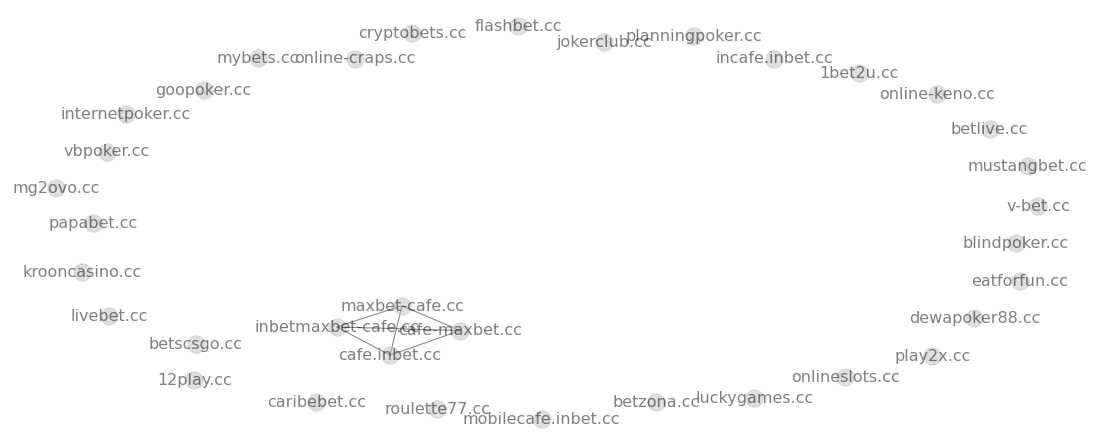

In [403]:
drawGraph(identifiersDF, 'Site', 'UA')

### SITES LINKED BY GOOGLE PUB IDENT

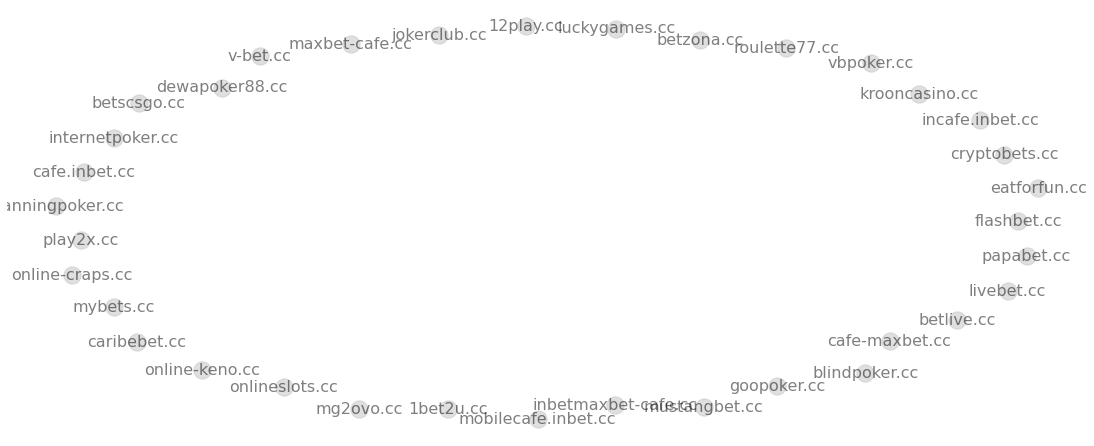

In [404]:
drawGraph(identifiersDF, 'Site', 'PUB')

### SITES LINKED BY YANDEX IDENT

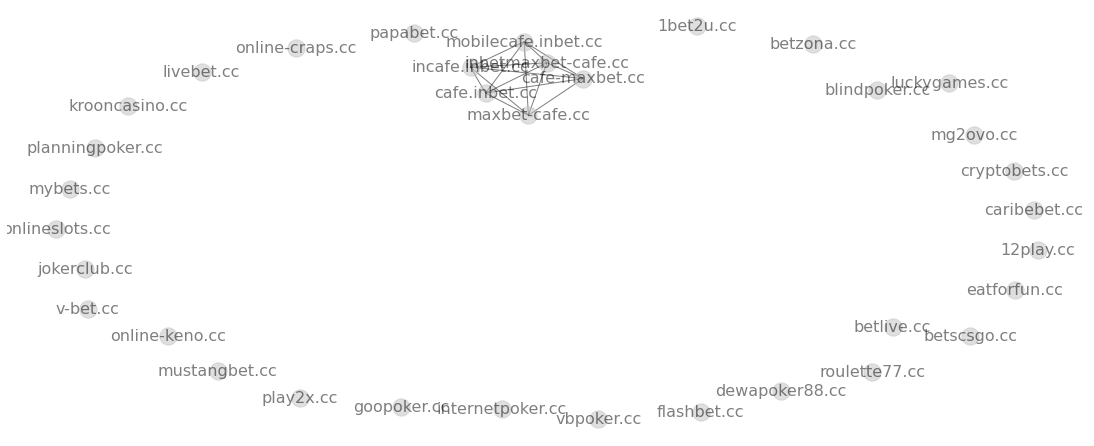

In [405]:
drawGraph(identifiersDF, 'Site', 'YM')

### SITES LINKED BY oceanside247

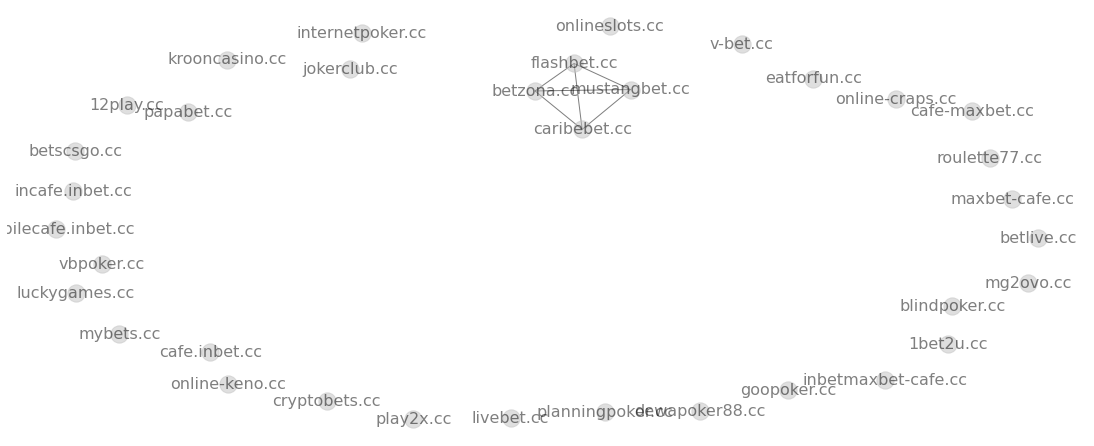

In [407]:
drawGraph(identifiersDF, 'Site', 'oceanside247')

### LICENSED SITES*

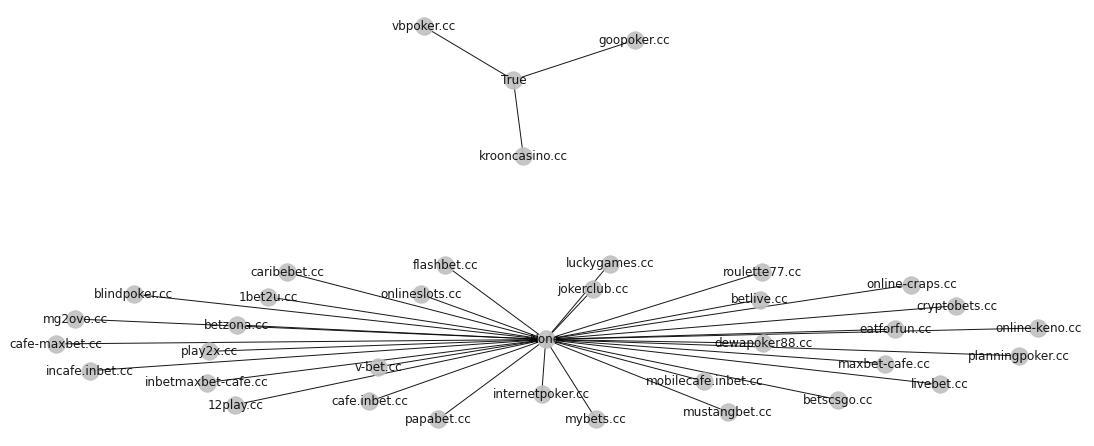

In [408]:
G = nx.Graph()
G = nx.from_pandas_edgelist(identifiersDF, 'Site', 'license')
plt.figure(1,figsize=(15,6)) 
pos = nx.spring_layout(G,k=0.15,iterations=20)
nx.draw(G, pos, alpha=.9, with_labels=True, node_color="silver", font_color="k")
plt.show()

### MULTIPLE CONNECTIONS

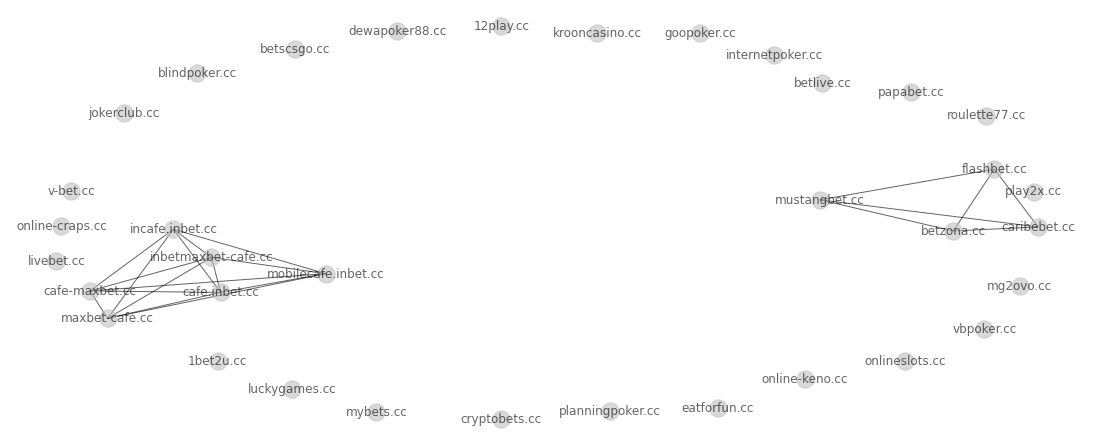

In [410]:
def multiGraph(graphDF):

    G = nx.Graph()

    ### ADD NODE
    for index, row in graphDF.iterrows():
        a = row['Site']
        
        b1 = row['UA']
        b2 = row['YM']
        b3 = row['oceanside247']

        G.add_node(a)

        ## FIND EDGE
        for index, row in graphDF.iterrows():
            A = row['Site']
            B1 = row['UA']

            if b1 != None:
                if b1 == B1:
                    G.add_edge(a,A)
                    
                    
        ## FIND EDGE
        for index, row in graphDF.iterrows():
            A = row['Site']
            B2 = row['YM']

            if b2 != None:
                if b2 == B2:
                    G.add_edge(a,A)
                    
        ## FIND EDGE
        for index, row in graphDF.iterrows():
            A = row['Site']
            B3 = row['oceanside247']

            if b3 != None:
                if b3 == B3:
                    G.add_edge(a,A)
                    
    plt.figure(1,figsize=(15,6)) 
    #nx.draw(G, alpha=.4, with_labels=True)
    pos = nx.spring_layout(G,k=1.5,iterations=100)
    nx.draw(G, pos, alpha=.6, with_labels=True, font_color="k", node_color="silver")
    plt.show()
    
multiGraph(identifiersDF)

### LOCATION OF (1st) IP ADDRESSES

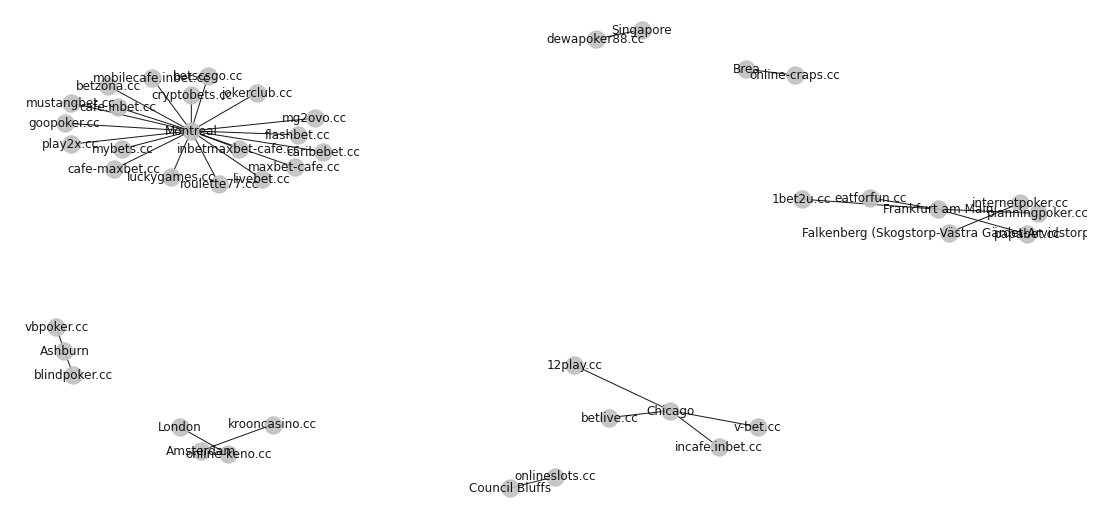

In [145]:
def drawHubs(df, field1, field2):
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, field1, field2)

    plt.figure(1,figsize=(15,7)) 
    pos = nx.spring_layout(G,k=0.5,iterations=100)
    nx.draw(G, pos, alpha=.9, with_labels=True, font_color='k', node_color="silver")
    plt.show()
    
drawHubs(identifiersDF, 'IP_1: City', 'Site')

### Is location related to the company hosting their site?

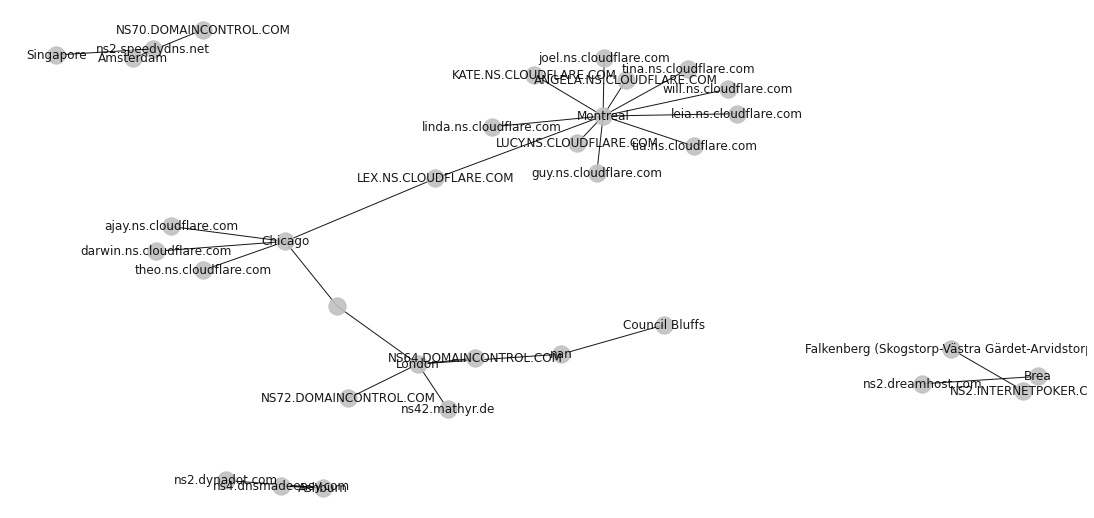

In [419]:
drawHubs(identifiersDF, 'IP_1: City', 'Name Server')

### Site Registrant Locations

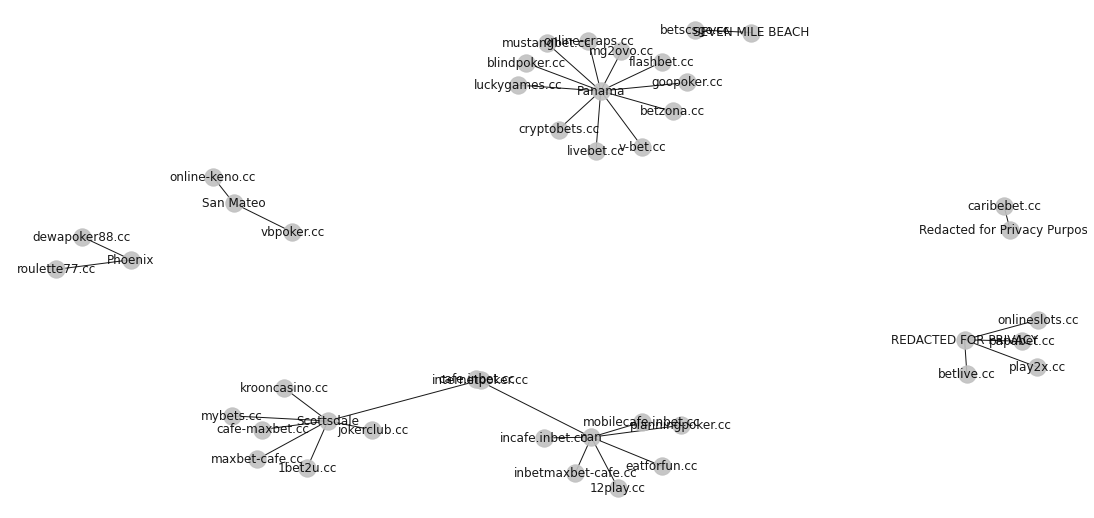

In [422]:
drawHubs(identifiersDF, 'Admin City', 'Site')

### Is that related to who is registering them (and is it a secrecy organisation)?

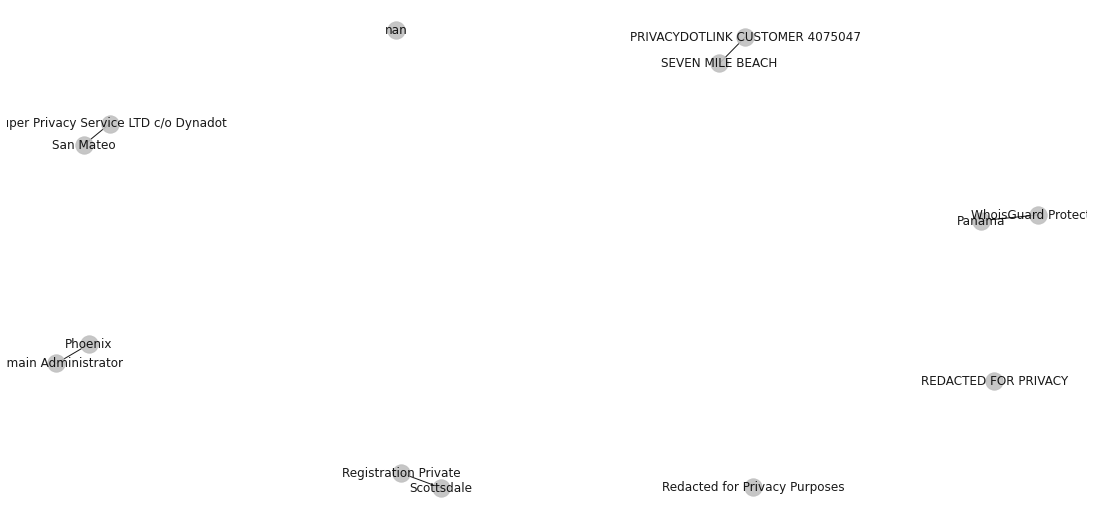

In [423]:
drawHubs(identifiersDF, 'Admin City', 'Admin Name')

# Is there a link between IP City and Registrant City? 

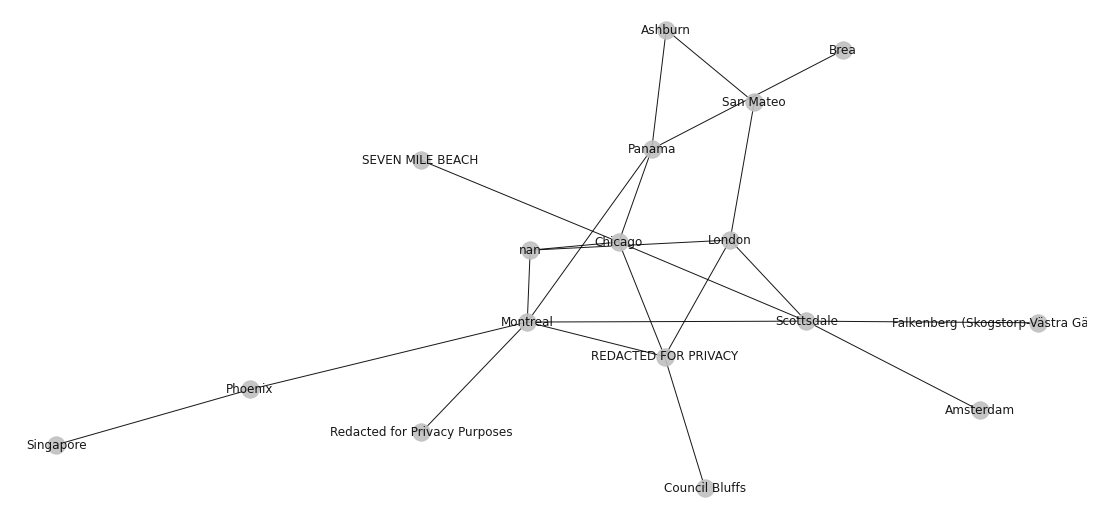

In [424]:
drawHubs(identifiersDF, 'Admin City', 'IP_1: City')

In [149]:
### drawHubs(identifiersDF, 'Historic Name 0', 'Site')

## TAKING DBD FURTHER

I HAVE ALSO BUILT A BETTER SCRIPT FOR BUILDING A NETWORK AALYSIS FROM DOMAINDATABASE:
https://github.com/jckkrr/WEBSITE-OWNERSHIP-NETWORK-ANALYSIS/blob/main/WEB%20OWNERSHIP%20NETWORK%20ANALYSIS%20202011161929.ipynb

THIS IS AN EARLIER, NON-MIDULAR VERSION

In [200]:
G = nx.Graph()

#COCOS SITES WITH OCEANSIDE247 IN CODE 
G.add_edge('flashbet.cc','caribebet.cc')
G.add_edge('flashbet.cc','betzona.cc')
G.add_edge('flashbet.cc','mustangbet.cc')
G.add_edge('caribebet.cc','betzona.cc')
G.add_edge('caribebet.cc','mustangbet.cc')
G.add_edge('betzona.cc','mustangbet.cc')
G.add_edge('flashbet.cc','oceanside247.com')
G.add_edge('caribebet.cc','oceanside247.com')
G.add_edge('mustangbet.cc','oceanside247.com')
G.add_edge('betzona.cc','oceanside247.com')

# MUSTANGBET USES LUCKYDOG CODE
G.add_edge('mustangbet.cc', 'luckydog.in')

# LUCKYDOG USES OCEANSIDE247 AND SPORTACTION 77 CODE
G.add_edge('luckydog.in','oceanside247.com')
G.add_edge('luckydog.in','SportsAction77.com')

# OCEANSIDE247 USES SPORTACTION 77
G.add_edge('oceanside247.com','SportsAction77.com')

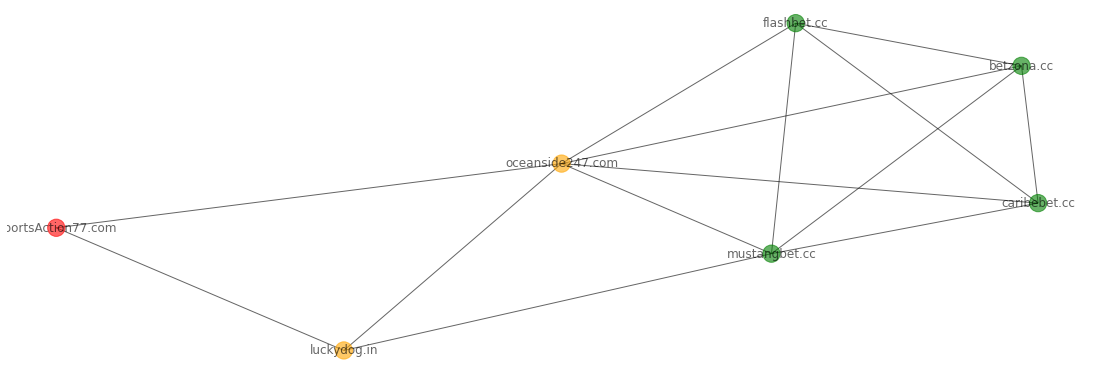

In [201]:
def colorGraph(height):

    color_map = []
    for node in G:
        if ".cc" in node:
            color_map.append('green')

        elif node == 'luckydog.in' or node == 'oceanside247.com':
            color_map.append('orange')

        elif ".com" in str(node) or ".net" in str(node) or ".in" in str(node) or ".me" in str(node): 
            color_map.append('red')

        elif node == "APPTITUDECR":
            color_map.append('yellow')

        else:
            color_map.append('blue') 

    plt.figure(1,figsize=(15,height)) 
    pos = nx.spring_layout(G,k=0.5,iterations=150)
    nx.draw(G, pos, alpha=.6, with_labels=True, node_color=color_map, font_color="k")
    plt.show()
    
colorGraph(5)

In the graph above, the blue dots represent sites in the checklist. 

The orange are those directly connected to the blue. And red is those not connected to the checklist nodes.

Looking at DBD again, we find that SportsAction77 and OceanSide247 have the same registrant: Juan Pablo Rosales

LuckyDog.in has a different registrant, and many more details about them.

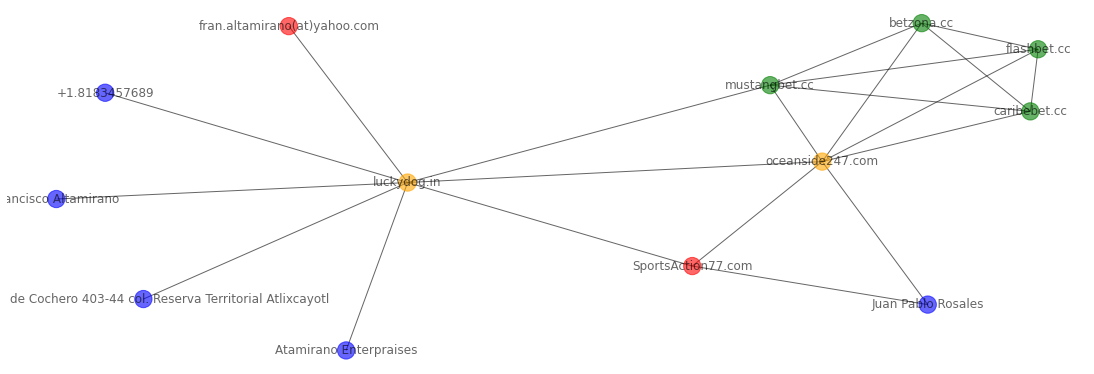

In [202]:
#first DBD links 

G.add_edge('oceanside247.com', 'Juan Pablo Rosales')
G.add_edge('SportsAction77.com', 'Juan Pablo Rosales')

G.add_edge('luckydog.in', 'Francisco Altamirano')
G.add_edge('luckydog.in', 'Atamirano Enterpraises')
G.add_edge('luckydog.in', 'fran.altamirano(at)yahoo.com')
G.add_edge('luckydog.in', '+1.8183457689')
G.add_edge('luckydog.in', 'Av. Zeta de Cochero 403-44 col. Reserva Territorial Atlixcayotl')

colorGraph(5)

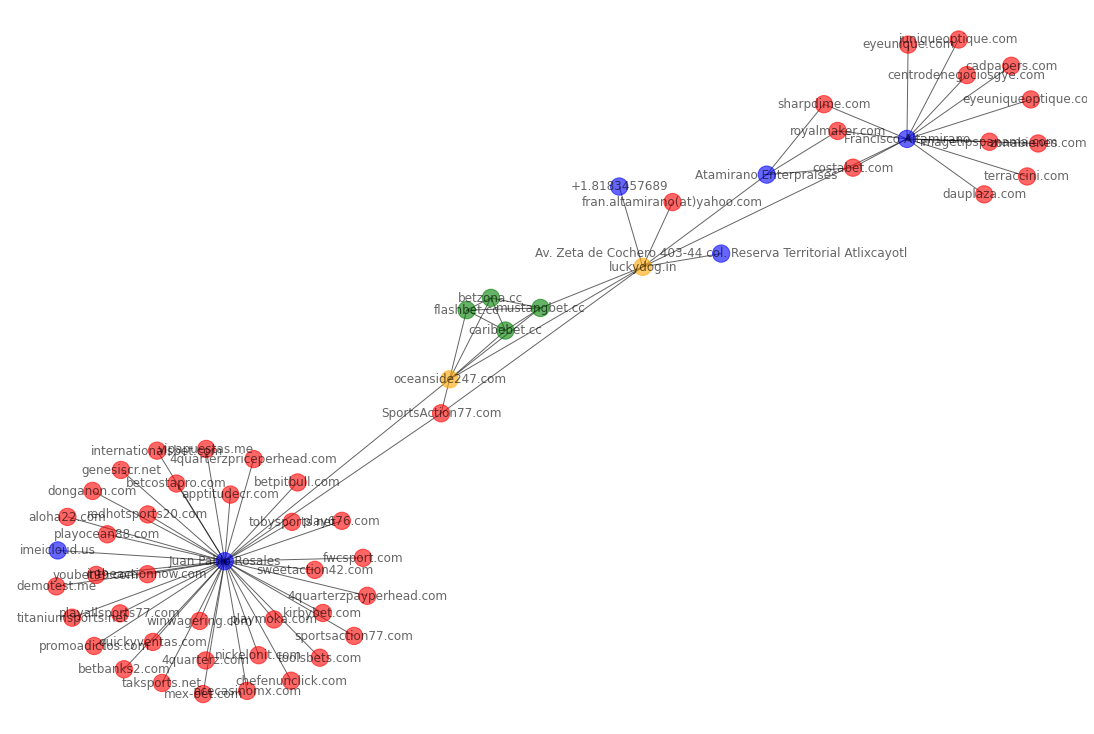

In [203]:
temp = {}
def DBDowner(url, node):
    
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    j = soup.find_all(id='aDomain')

    for i in j:
        site = i.contents[0]
        #h = 'https://domainbigdata.com' + i.get("href")
        #temp[site] = dict(site=site, href=h)
        
        G.add_edge(site, node)

    
DBDowner('https://domainbigdata.com/nj/uv-MeAI6bqoQg0bC5DqADt_w3bw4BWqQu6ZDENsfWak', 'Juan Pablo Rosales')
DBDowner('https://domainbigdata.com/nj/1fIjpu-K1eIqJBiVNRaKPJXy2cNdVxvQIZi7uQrToxI', 'Francisco Altamirano')
DBDowner('https://domainbigdata.com/nj/3iQKnRVoGBDVEN1OT2Kb61nEKBPtwiMTL0liiP5RXTA', 'Atamirano Enterpraises')


colorGraph(10)

Looking through the links, we see that Juan Pablo Rosales seems to be heavily linked to the company Apptitidecr

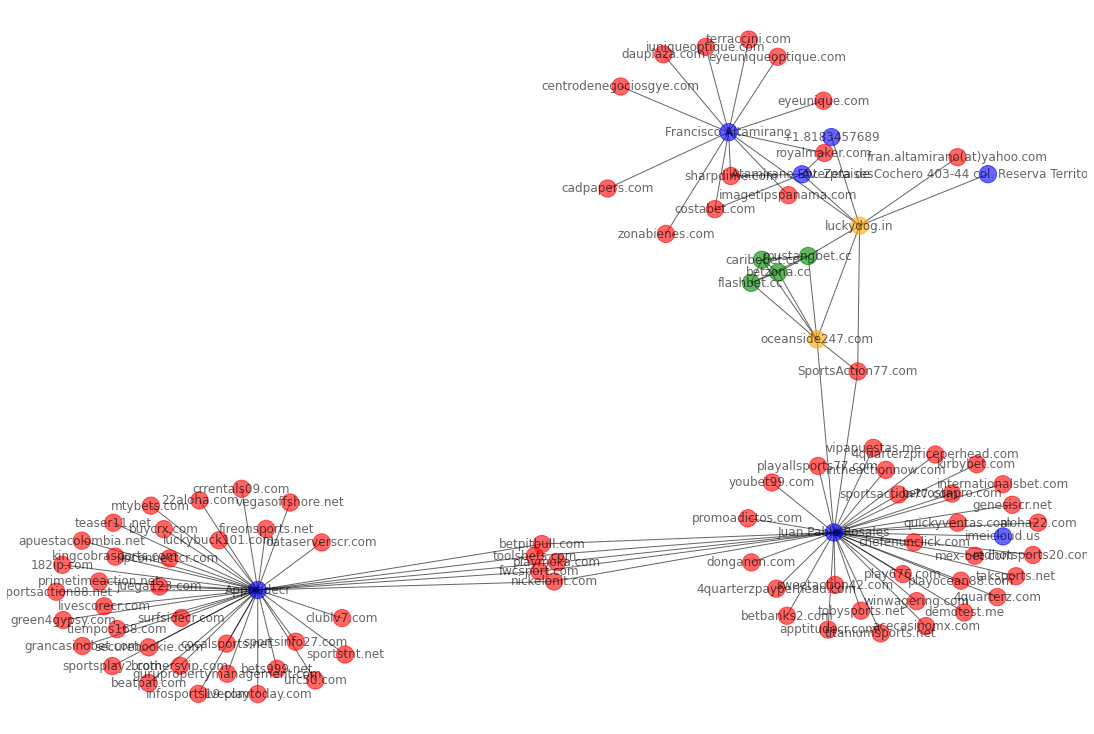

In [204]:
DBDowner('https://domainbigdata.com/nj/PlePTcUBedfpcmHo4GSm0g', 'Apptitidecr')
colorGraph(10)

... and to the email address Pablo2412@gmail.com

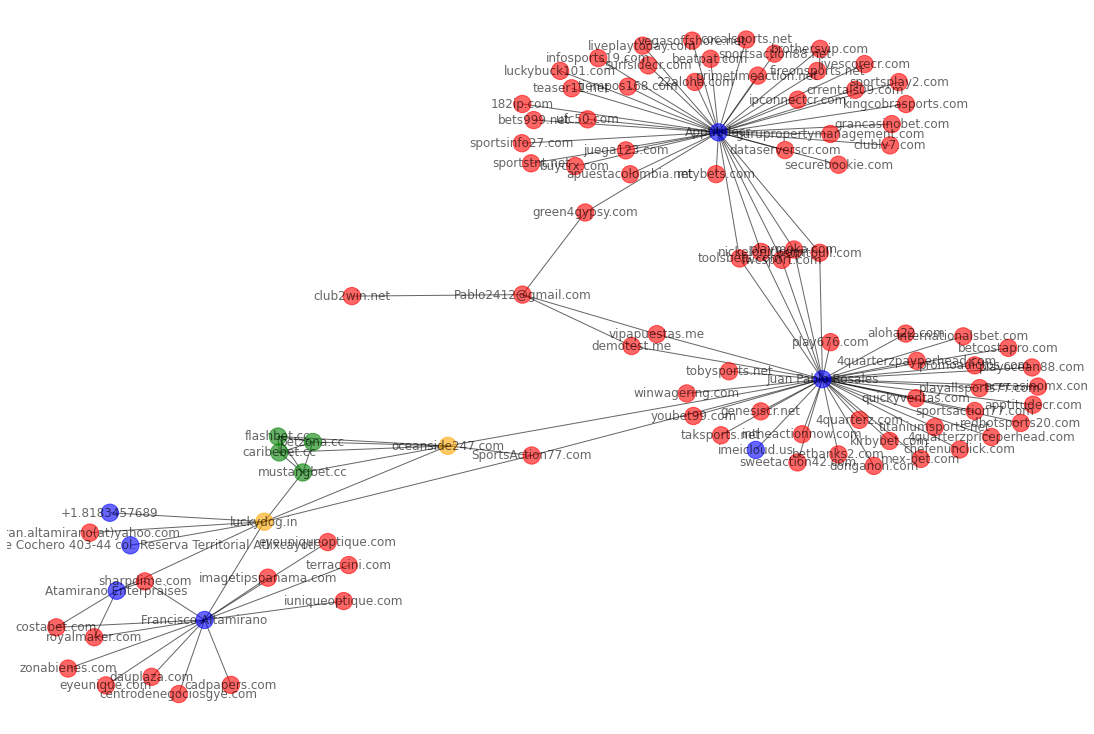

In [205]:
DBDowner('https://domainbigdata.com/gmail.com/mj/91SRB4RXW30z64NsR1_8zA', 'Pablo2412@gmail.com')
colorGraph(10)

One of the those new sites regsitered with his email address uses a variation on his name: Juan P M.

And another variation is listed on the page for his email address: Pablo Rosales


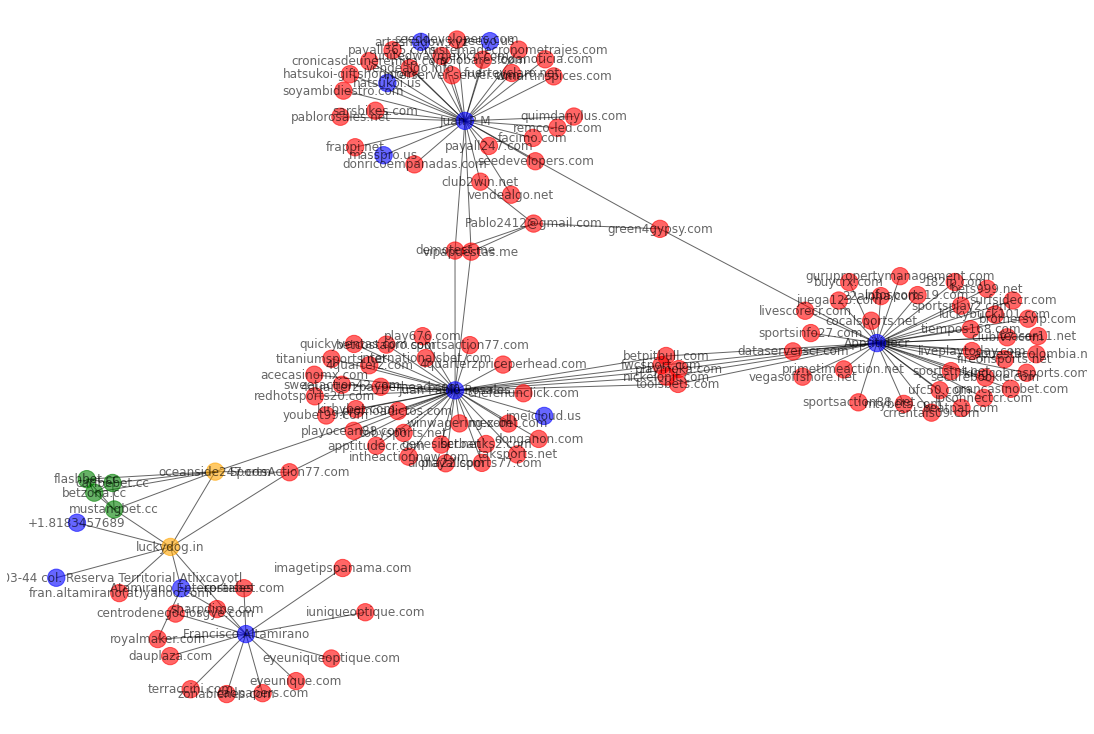

In [206]:
DBDowner('https://domainbigdata.com/gmail.com/mj/91SRB4RXW30z64NsR1_8zA', 'Juan P M')
DBDowner('https://domainbigdata.com/nj/tUd3nzIhz9q9FWqIJj762w', 'Juan P M')
colorGraph(10)

Now lets look at the links from ApptitudeCR (in this very non-concise piece of code).

In [207]:
d = {}

def getInfo(shortname, idequals,dname, v):
        
        try:
            if v == 'A':    
                shortname = soup2.find(id=idequals).find("a").contents[0]
                
            if v == 'B':    
                shortname = soup2.find(id=idequals).find_all("td")[1].find('a').contents[0]
                            
            d[site][dname] = shortname
        except:
            shortname = None

        
url = 'https://domainbigdata.com/nj/PlePTcUBedfpcmHo4GSm0g'
    
page = requests.get(url)                                
soup = BeautifulSoup(page.content, 'html.parser')
j = soup.find_all(id='aDomain')

for i in j:
    site = i.contents[0]
    h = 'https://domainbigdata.com' + i.get("href")
    d[site] = dict(site=site, href=h)
    
    page2 = requests.get(h)
    soup2 = BeautifulSoup(page2.content, 'html.parser')
    
    regname, regorg, regemail  = None, None, None
    getInfo(regname, "trRegistrantName", 'Registrant Name', 'B')
    getInfo(regorg, 'MainMaster_trRegistrantOrganization', 'Registrant Organisation', 'A')
    getInfo(regemail, "trRegistrantEmail", 'Registrant Email', 'B')
    

    
    # GET HISTORICAL INFO FROM EACH LINKS PAGE
    page3 = requests.get(h)                                
    soup3 = BeautifulSoup(page3.content, 'html.parser')

    j3 = soup3.find_all(id='divRptHistoryMain')

    historic = {}

    for n in range(0,len(j3)):
    
        try:
            recorded = j3[n].find(id='MainMaster_rptWhoisHistory_h2InRpt_' + str(n)).contents[0]
            recorded = recorded.split(':')[1].strip()
        except:
            recorded = None
            

        try:
            historicName  = j3[n].find(id='trRegistrantNameInRpt')               
            if historicName.find('a') != None:
                historicName = historicName.find_all("td")[1].find('a').contents[0]
            else:
                historicName = historicName.find_all("td")[1].contents[0]           
        except:
            historicName = None

        try:
            historicReg  = j3[n].find(id='MainMaster_rptWhoisHistory_trRegistrantOrganizationInRpt_' + str(n)).find_all("td")[1]
            if historicReg.find('a') != None:
                historicReg = historicReg.find('a').contents[0]
            else:
                historicReg = historicReg.contents[0]   
        except:
            historicReg = None


        try:
            historicEmail  = j3[n].find(id='trRegistrantEmailInRpt')               
            if historicEmail.find('a') != None:
                historicEmail = historicEmail.find_all("td")[1].find('a').contents[0]
            else:
                historicEmail = historicEmail.find_all("td")[1].contents[0]           
        except:
            historicEmail = None


        historic[n] = dict(recorded=recorded, historicName=historicName, historicReg=historicReg, historicEmail=historicEmail)
        #flatten 
        for kk, vv in historic.items():
            for k,v in historic[kk].items():
                name = k + '_' + str(kk)
                d[site][name] = v 


    print('.', end="")
    
  
  
df = pd.DataFrame(d).T
df.head()

.......................................

site  \
surfsidecr.com            surfsidecr.com   
brothersvip.com          brothersvip.com   
22aloha.com                  22aloha.com   
primetimeaction.net  primetimeaction.net   
playmoka.com                playmoka.com   

                                                              href  \
surfsidecr.com            https://domainbigdata.com/surfsidecr.com   
brothersvip.com          https://domainbigdata.com/brothersvip.com   
22aloha.com                  https://domainbigdata.com/22aloha.com   
primetimeaction.net  https://domainbigdata.com/primetimeaction.net   
playmoka.com                https://domainbigdata.com/playmoka.com   

                    Registrant Organisation  recorded_0      historicName_0  \
surfsidecr.com                  Apptitudecr  2019-02-16                None   
brothersvip.com                 Apptitudecr         NaN                 NaN   
22aloha.com                     Apptitudecr         NaN                 NaN   
primetimeaction.net             Apptitudecr         NaN                 NaN   
playmoka.com                    Apptitudecr  2015-06-19  Juan Pablo Rosales   

                    historicReg_0 historicEmail_0  recorded_1  \
surfsidecr.com        Apptitudecr            None  2016-09-24   
brothersvip.com               NaN             NaN         NaN   
22aloha.com                   NaN             NaN         NaN   
primetimeaction.net           NaN             NaN         NaN   
playmoka.com                 None            None         NaN   

                                               historicName_1  \
surfsidecr.com       Contact Privacy Inc. Customer 0141346021   
brothersvip.com                                           NaN   
22aloha.com                                               NaN   
primetimeaction.net                                       NaN   
playmoka.com                                              NaN   

                                                historicReg_1  \
surfsidecr.com       Contact Privacy Inc. Customer 0141346021   
brothersvip.com                                           NaN   
22aloha.com                                               NaN   
primetimeaction.net                                       NaN   
playmoka.com                                              NaN   

                                          historicEmail_1  \
surfsidecr.com       surfsidecr.com(at)contactprivacy.com   
brothersvip.com                                       NaN   
22aloha.com                                           NaN   
primetimeaction.net                                   NaN   
playmoka.com                                          NaN   

                             Registrant Name Registrant Email  
surfsidecr.com                           NaN              NaN  
brothersvip.com      Apptitudecr It Services              NaN  
22aloha.com                              NaN              NaN  
primetimeaction.net                      NaN              NaN  
playmoka.com                             NaN              NaN

In [208]:
for index, row in df.iterrows():
    a = row['site']
    b = row['Registrant Organisation']
    c = row['historicReg_0']
    d = row['historicReg_1']
    e = row['historicName_0']
    f = row['historicName_1']
    g = row['historicEmail_0']
    h = row['historicEmail_1']
    i = row['Registrant Email']
    
    
    
    
    if pd.isnull(b) == False:
        if b != None:
            G.add_edge(a,b)
    if pd.isnull(c) == False:
        if c != None:
            G.add_edge(a,c)
    if pd.isnull(d) == False:
        if d != None:
            G.add_edge(a,d)
    if pd.isnull(e) == False:
        if e != None:
            G.add_edge(a,e)
    if pd.isnull(f) == False:
        if f != None:
            G.add_edge(a,f)
    if pd.isnull(g) == False:
        if g != None:
            G.add_edge(a,g)
    if pd.isnull(h) == False:
        if h != None:
            G.add_edge(a,h)
    if pd.isnull(i) == False:
        if i != None:
            G.add_edge(a,i)

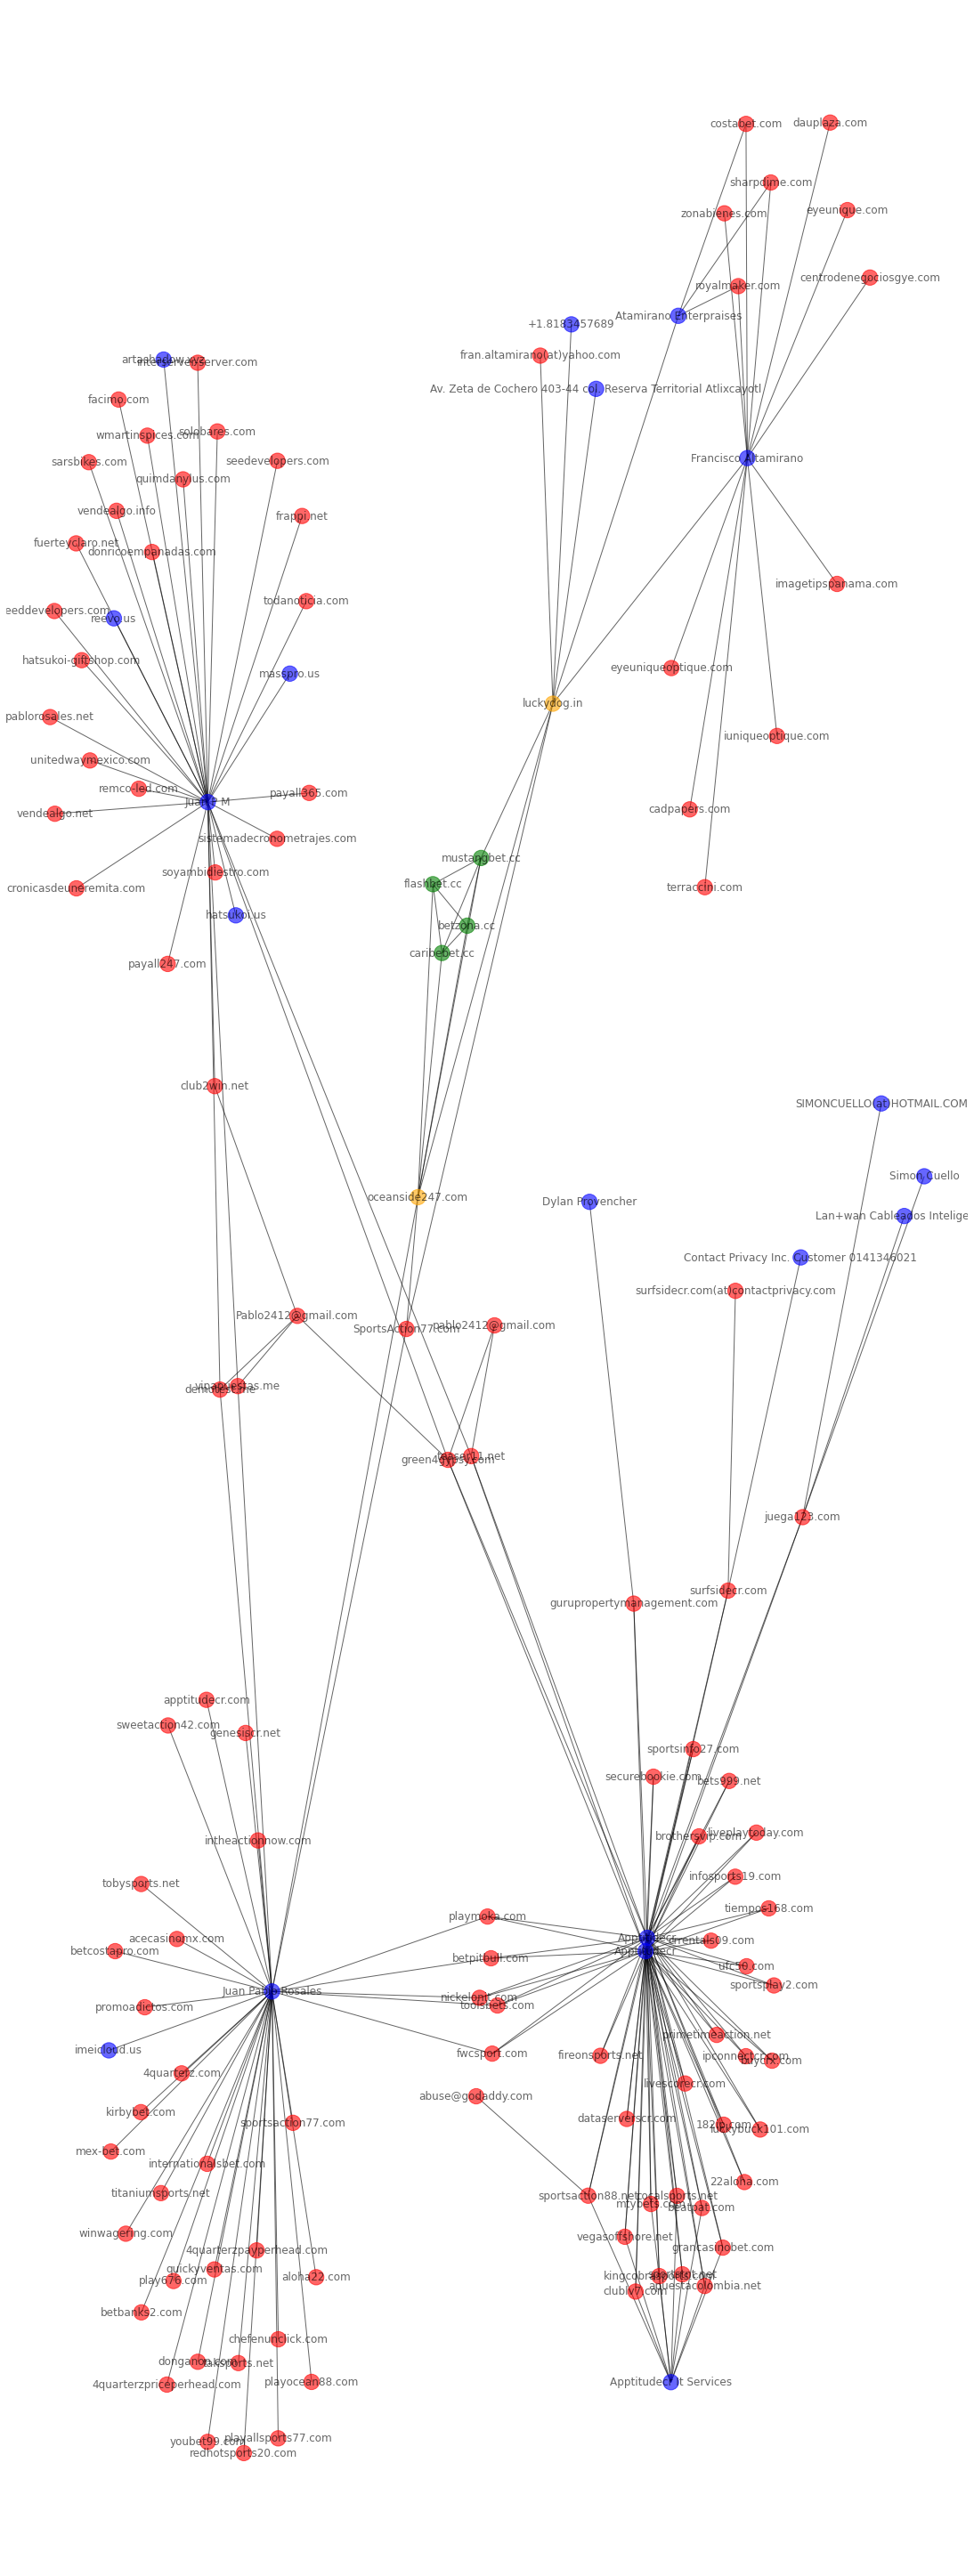

In [209]:
colorGraph(40)

And now Altamarino

In [210]:
d = {}

def getInfo(shortname, idequals,dname, v):
        
        try:
            if v == 'A':    
                shortname = soup2.find(id=idequals).find("a").contents[0]
                
            if v == 'B':    
                shortname = soup2.find(id=idequals).find_all("td")[1].find('a').contents[0]
                            
            d[site][dname] = shortname
        except:
            shortname = None

        
url = 'https://domainbigdata.com/nj/3iQKnRVoGBDVEN1OT2Kb61nEKBPtwiMTL0liiP5RXTA'
    
page = requests.get(url)                                
soup = BeautifulSoup(page.content, 'html.parser')
j = soup.find_all(id='aDomain')

for i in j:
    site = i.contents[0]
    h = 'https://domainbigdata.com' + i.get("href")
    d[site] = dict(site=site, href=h)
    
    page2 = requests.get(h)
    soup2 = BeautifulSoup(page2.content, 'html.parser')
    
    regname, regorg, regemail  = None, None, None
    getInfo(regname, "trRegistrantName", 'Registrant Name', 'B')
    getInfo(regorg, 'MainMaster_trRegistrantOrganization', 'Registrant Organisation', 'A')
    getInfo(regemail, "trRegistrantEmail", 'Registrant Email', 'B')
    

    
    # GET HISTORICAL INFO FROM EACH LINKS PAGE
    page3 = requests.get(h)                                
    soup3 = BeautifulSoup(page3.content, 'html.parser')

    j3 = soup3.find_all(id='divRptHistoryMain')

    historic = {}

    for n in range(0,len(j3)):
    
        try:
            recorded = j3[n].find(id='MainMaster_rptWhoisHistory_h2InRpt_' + str(n)).contents[0]
            recorded = recorded.split(':')[1].strip()
        except:
            recorded = None
            

        try:
            historicName  = j3[n].find(id='trRegistrantNameInRpt')               
            if historicName.find('a') != None:
                historicName = historicName.find_all("td")[1].find('a').contents[0]
            else:
                historicName = historicName.find_all("td")[1].contents[0]           
        except:
            historicName = None

        try:
            historicReg  = j3[n].find(id='MainMaster_rptWhoisHistory_trRegistrantOrganizationInRpt_' + str(n)).find_all("td")[1]
            if historicReg.find('a') != None:
                historicReg = historicReg.find('a').contents[0]
            else:
                historicReg = historicReg.contents[0]   
        except:
            historicReg = None


        try:
            historicEmail  = j3[n].find(id='trRegistrantEmailInRpt')               
            if historicEmail.find('a') != None:
                historicEmail = historicEmail.find_all("td")[1].find('a').contents[0]
            else:
                historicEmail = historicEmail.find_all("td")[1].contents[0]           
        except:
            historicEmail = None


        historic[n] = dict(recorded=recorded, historicName=historicName, historicReg=historicReg, historicEmail=historicEmail)
        #flatten 
        for kk, vv in historic.items():
            for k,v in historic[kk].items():
                name = k + '_' + str(kk)
                d[site][name] = v 


    print('.', end="")
    
  
  
df = pd.DataFrame(d).T
df.head()

....

site                                      href  \
royalmaker.com  royalmaker.com  https://domainbigdata.com/royalmaker.com   
sharpdime.com    sharpdime.com   https://domainbigdata.com/sharpdime.com   
luckydog.in        luckydog.in     https://domainbigdata.com/luckydog.in   
costabet.com      costabet.com    https://domainbigdata.com/costabet.com   

                     Registrant Name Registrant Organisation  \
royalmaker.com  Francisco Altamirano  Atamirano Enterpraises   
sharpdime.com   Francisco Altamirano  Atamirano Enterpraises   
luckydog.in     Francisco Altamirano  Atamirano Enterpraises   
costabet.com    Whoisguard Protected          Whoisguard Inc   

                      Registrant Email  recorded_0        historicName_0  \
royalmaker.com  frankaltamir@yahoo.com  2016-01-15  Francisco Altamirano   
sharpdime.com   frankaltamir@yahoo.com  2018-02-23  Whoisguard Protected   
luckydog.in                        NaN  2016-05-29  Francisco Altamirano   
costabet.com                       NaN  2018-06-15  Francisco Altamirano   

                         historicReg_0  \
royalmaker.com  Atamirano Enterpraises   
sharpdime.com           Whoisguard Inc   
luckydog.in     Atamirano Enterpraises   
costabet.com    Atamirano Enterpraises   

                                                  historicEmail_0  recorded_1  \
royalmaker.com                             frankaltamir@yahoo.com         NaN   
sharpdime.com   ad1e4c9e4b5240cb96c2e187c356f496.protect(at)wh...  2013-08-22   
luckydog.in                          fran.altamirano(at)yahoo.com         NaN   
costabet.com                               frankaltamir@yahoo.com  2015-10-25   

                      historicName_1           historicReg_1  \
royalmaker.com                   NaN                     NaN   
sharpdime.com                   None                    None   
luckydog.in                      NaN                     NaN   
costabet.com    Francisco Altamirano  Atamirano Enterpraises   

                       historicEmail_1  
royalmaker.com                     NaN  
sharpdime.com                     None  
luckydog.in                        NaN  
costabet.com    frankaltamir@yahoo.com

In [211]:
for index, row in df.iterrows():
    a = row['site']
    b = row['Registrant Organisation']
    c = row['historicReg_0']
    d = row['historicReg_1']
    e = row['historicName_0']
    f = row['historicName_1']
    g = row['historicEmail_0']
    h = row['historicEmail_1']
    i = row['Registrant Email']
    
    if pd.isnull(b) == False:
        if b != None:
            G.add_edge(a,b)
    if pd.isnull(c) == False:
        if c != None:
            G.add_edge(a,c)
    if pd.isnull(d) == False:
        if d != None:
            G.add_edge(a,d)
    if pd.isnull(e) == False:
        if e != None:
            G.add_edge(a,e)
    if pd.isnull(f) == False:
        if f != None:
            G.add_edge(a,f)
    if pd.isnull(g) == False:
        if g != None:
            G.add_edge(a,g)
    if pd.isnull(h) == False:
        if h != None:
            G.add_edge(a,h)
    if pd.isnull(i) == False:
        if i != None:
            G.add_edge(a,i)

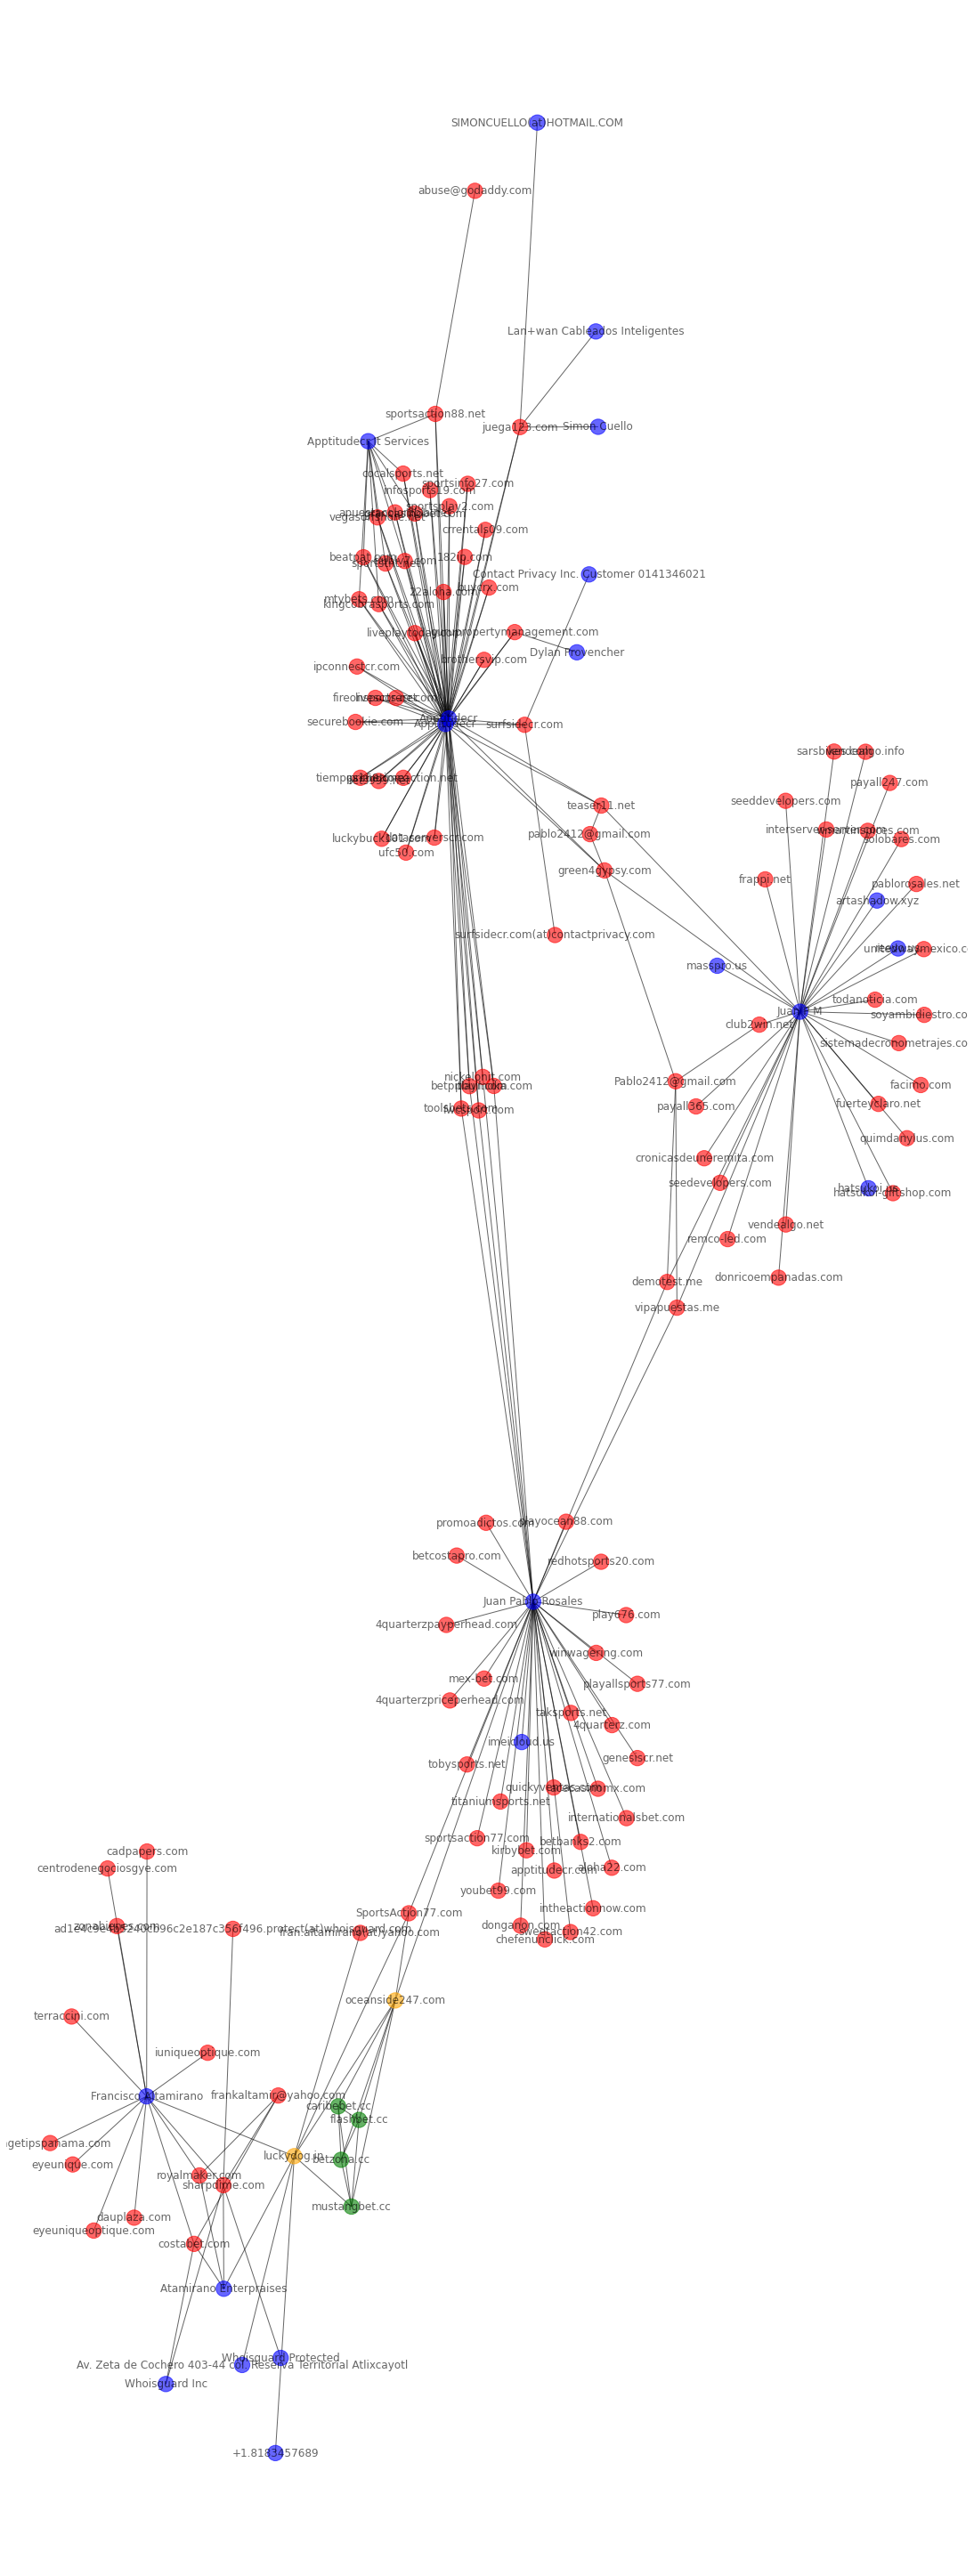

In [212]:
colorGraph(40)

And Juan Pablo

.....................................

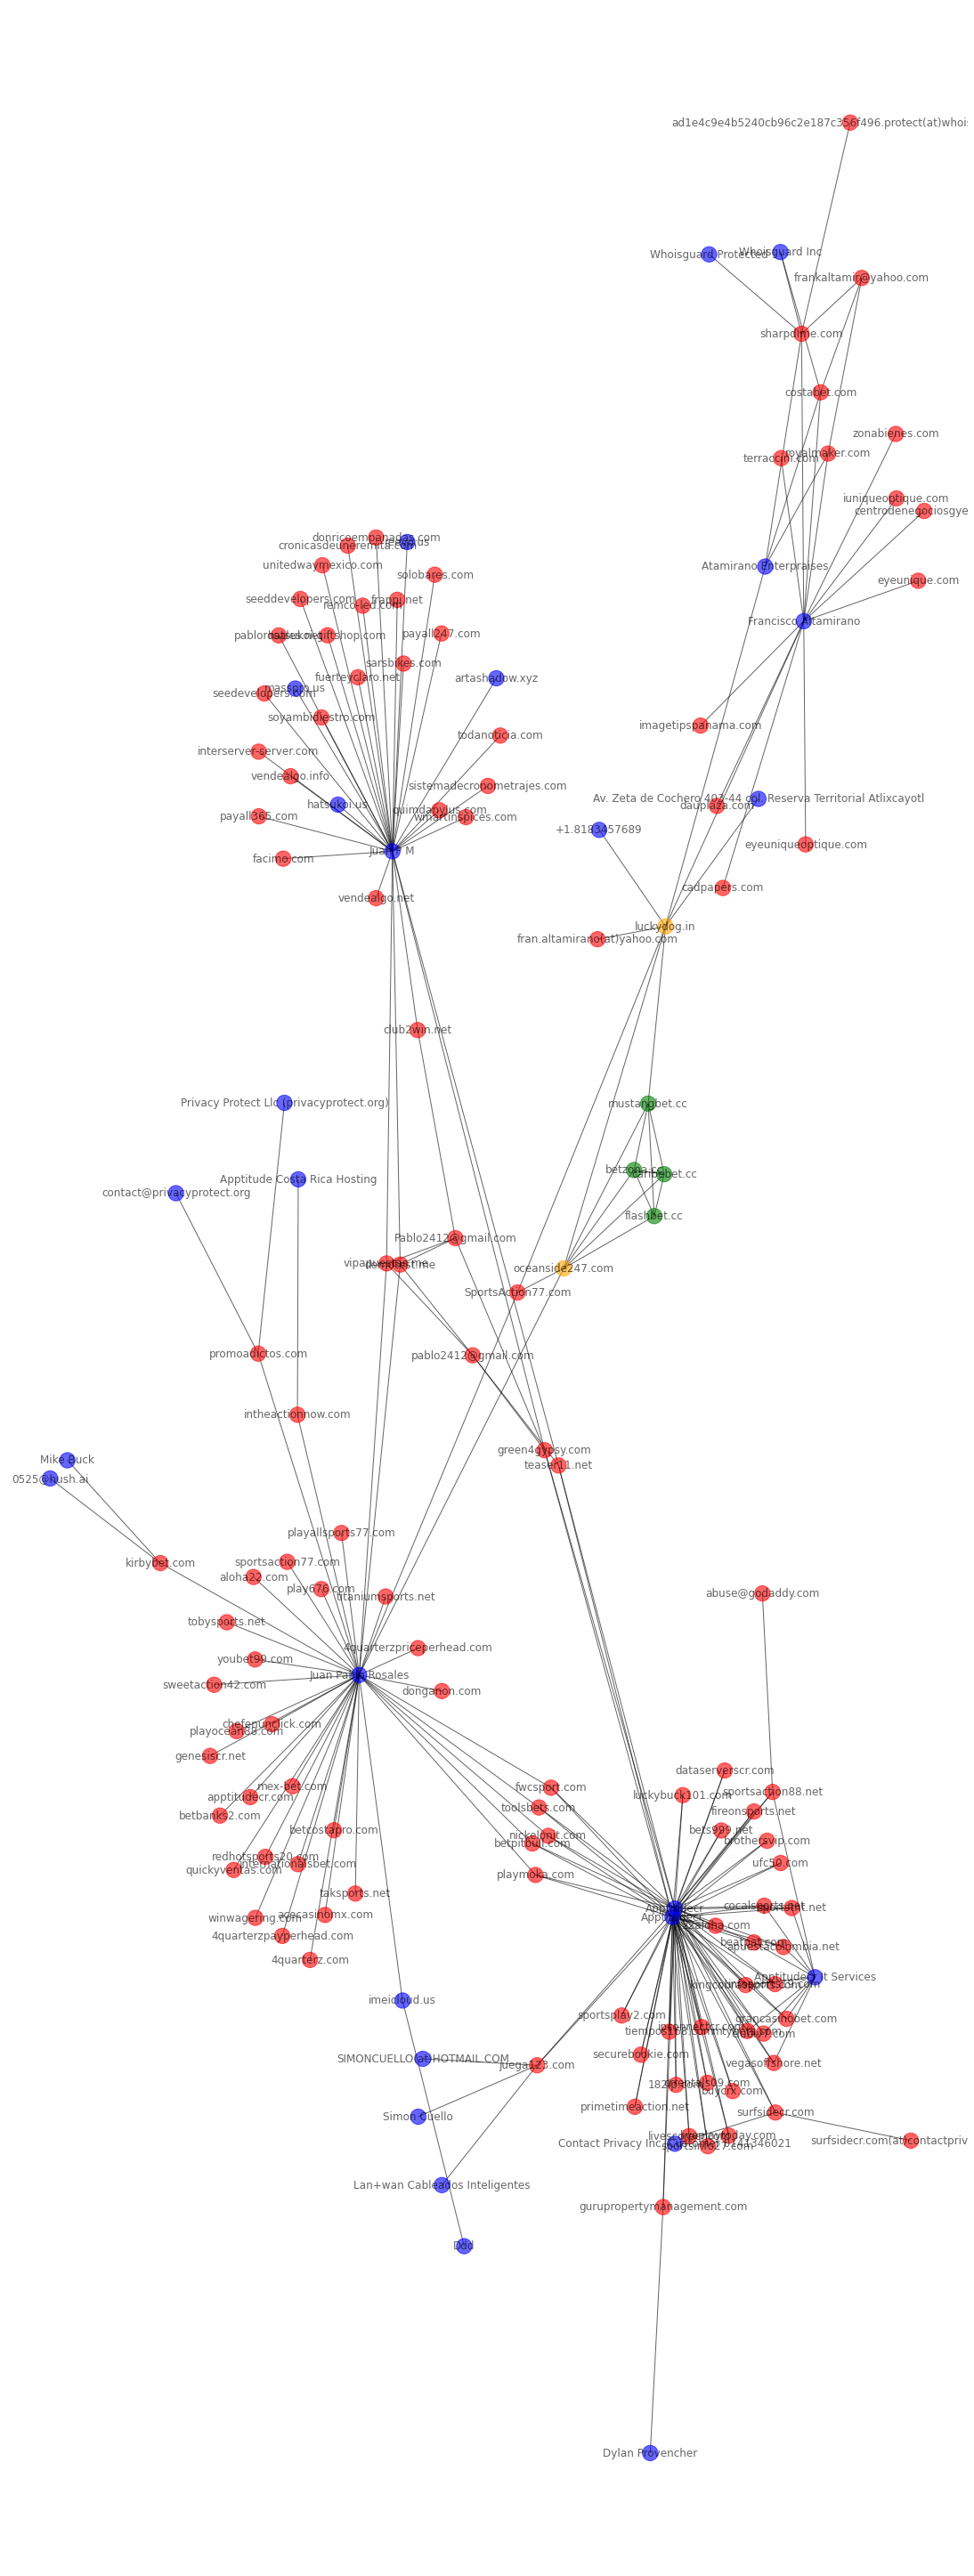

In [213]:
d = {}

def getInfo(shortname, idequals,dname, v):
        
        try:
            if v == 'A':    
                shortname = soup2.find(id=idequals).find("a").contents[0]
                
            if v == 'B':    
                shortname = soup2.find(id=idequals).find_all("td")[1].find('a').contents[0]
                            
            d[site][dname] = shortname
        except:
            shortname = None

        
url = 'https://domainbigdata.com/nj/uv-MeAI6bqoQg0bC5DqADt_w3bw4BWqQu6ZDENsfWak'
    
page = requests.get(url)                                
soup = BeautifulSoup(page.content, 'html.parser')
j = soup.find_all(id='aDomain')

for i in j:
    site = i.contents[0]
    h = 'https://domainbigdata.com' + i.get("href")
    d[site] = dict(site=site, href=h)
    
    page2 = requests.get(h)
    soup2 = BeautifulSoup(page2.content, 'html.parser')
    
    regname, regorg, regemail  = None, None, None
    getInfo(regname, "trRegistrantName", 'Registrant Name', 'B')
    getInfo(regorg, 'MainMaster_trRegistrantOrganization', 'Registrant Organisation', 'A')
    getInfo(regemail, "trRegistrantEmail", 'Registrant Email', 'B')
    

    
    # GET HISTORICAL INFO FROM EACH LINKS PAGE
    page3 = requests.get(h)                                
    soup3 = BeautifulSoup(page3.content, 'html.parser')

    j3 = soup3.find_all(id='divRptHistoryMain')

    historic = {}

    for n in range(0,len(j3)):
    
        try:
            recorded = j3[n].find(id='MainMaster_rptWhoisHistory_h2InRpt_' + str(n)).contents[0]
            recorded = recorded.split(':')[1].strip()
        except:
            recorded = None
            

        try:
            historicName  = j3[n].find(id='trRegistrantNameInRpt')               
            if historicName.find('a') != None:
                historicName = historicName.find_all("td")[1].find('a').contents[0]
            else:
                historicName = historicName.find_all("td")[1].contents[0]           
        except:
            historicName = None

        try:
            historicReg  = j3[n].find(id='MainMaster_rptWhoisHistory_trRegistrantOrganizationInRpt_' + str(n)).find_all("td")[1]
            if historicReg.find('a') != None:
                historicReg = historicReg.find('a').contents[0]
            else:
                historicReg = historicReg.contents[0]   
        except:
            historicReg = None


        try:
            historicEmail  = j3[n].find(id='trRegistrantEmailInRpt')               
            if historicEmail.find('a') != None:
                historicEmail = historicEmail.find_all("td")[1].find('a').contents[0]
            else:
                historicEmail = historicEmail.find_all("td")[1].contents[0]           
        except:
            historicEmail = None


        historic[n] = dict(recorded=recorded, historicName=historicName, historicReg=historicReg, historicEmail=historicEmail)
        #flatten 
        for kk, vv in historic.items():
            for k,v in historic[kk].items():
                name = k + '_' + str(kk)
                d[site][name] = v 


    print('.', end="")
    
  
  
df = pd.DataFrame(d).T


for index, row in df.iterrows():
    a = row['site']
    b = row['Registrant Organisation']
    c = row['historicReg_0']
    d = row['historicReg_1']
    e = row['historicName_0']
    f = row['historicName_1']
    g = row['historicEmail_0']
    h = row['historicEmail_1']
    i = row['Registrant Email']
    
    if pd.isnull(b) == False:
        if b != None:
            G.add_edge(a,b)
    if pd.isnull(c) == False:
        if c != None:
            G.add_edge(a,c)
    if pd.isnull(d) == False:
        if d != None:
            G.add_edge(a,d)
    if pd.isnull(e) == False:
        if e != None:
            G.add_edge(a,e)
    if pd.isnull(f) == False:
        if f != None:
            G.add_edge(a,f)
    if pd.isnull(g) == False:
        if g != None:
            G.add_edge(a,g)
    if pd.isnull(h) == False:
        if h != None:
            G.add_edge(a,h)
    if pd.isnull(i) == False:
        if i != None:
            G.add_edge(a,i)

colorGraph(40)

Obviously the next step is to completly automate it, so it finds all nodes in the network. But it has served its purpose: I have now contacts for the owners of four sites in my original chekclist.